## Exploring the headroom counter stats from the default.cm table - 1.7 with PyAsl (Generalized ESD Test for Outliers)

The purpose of this notebook is to explore counters data in the default.cm table of hive. Here we will mainly focus on the current_ops of the 'resource_headroom_cpu' object.

In [1]:
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns

import scipy as sp
from scipy.stats import norm
from PyAstronomy import pyasl

import statsmodels.api as sm

from datetime import datetime

# this allows plots to appear directly in the notebook
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 200)
#pd.set_option('display.max_rows', 500)
#pd.set_option('display.float_format', lambda x: '%.0f' % x)
plt.style.use('bmh')

/Users/anindyas/anaconda/envs/tensorflow/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Importing the data

In [2]:
# Load headroom data for serial no 211645000176 from 31st May to 30th June, 2017
# Why 31 days of data is collected and not 30days I will explain later
'''
select cm.asup_key,
cm.instance_name,
cm.prev_time_stamp, cm.cur_time_stamp, 
split(cm.counters['current_ops'],'\\|')[1] as prev_ops,
split(cm.counters['current_ops'],'\\|')[0] as cur_ops,
split(cm.counters['current_latency'],'\\|')[1] as prev_latency,
split(cm.counters['current_latency'],'\\|')[0] as cur_latency,
split(cm.counters['current_utilization'],'\\|')[1] as prev_utilization,
split(cm.counters['current_utilization'],'\\|')[0] as cur_utilization,
split(cm.counters['current_utilization_total'],'\\|')[1] as prev_utilization_total,
split(cm.counters['current_utilization_total'],'\\|')[0] as cur_utilization_total,
cm.dt
from default.cm, guestdb.asup_last_asup_key
where cm.dt >= '2017-04-30' and cm.dt <= '2017-07-31' 
and split(cm.asup_key,'\\|')[3] = '601429000472'
and cm.object_name ='resource_headroom_cpu'
and asup_last_asup_key.asup_key = cm.asup_key
and asup_last_asup_key.dt = regexp_replace(cm.dt, "-", "")
and asup_last_asup_key.asup_type = 'DOT-PERF'
and asup_last_asup_key.asup_subject like '%PERFORMANCE DATA%'
order by cm.cur_time_stamp;
'''
headroom_601429000472_hive = pd.read_table('601429000472_system_utilization_join_cm_asup.tsv', 
                              header=None, na_values = ['null', 'NULL'],
                              names=["asup_key", "instance_name", "prev_time_stamp", "cur_time_stamp",  
                                     "prev_ops", "cur_ops","prev_latency", "cur_latency", 
                                     "prev_utilization", "cur_utilization",
                                     "prev_utilization_total","cur_utilization_total","dt"],
                             usecols=["asup_key", "instance_name", "prev_time_stamp", "cur_time_stamp",  
                                     "prev_utilization", "cur_utilization",
                                     "prev_utilization_total","cur_utilization_total","dt"],
                                     low_memory = 'False')

### Pre-processing the data

In [3]:
# checking COUNT of data
# for 93 days we are expecting 2232 (24 * (1 + 31 + 30 + 31)) records since the data is collected hourly. Count is not matching
len(headroom_601429000472_hive)

2231

In [4]:
# Missing data
24 * (1 + 31 + 30 + 31) - len(headroom_601429000472_hive)

1

In [5]:
# Check for duplicate records if any
headroom_601429000472_hive.duplicated().value_counts()

False    2231
dtype: int64

Fortunately, there are no duplicate records for this serial number.

In [6]:
# convert the cur_time_stamp to a more human readable format
headroom_601429000472_hive["cur_time_in_gmt"] = pd.to_datetime(headroom_601429000472_hive["cur_time_stamp"], unit='s')

In [7]:
# check for a specific column if it has null values
#headroom_601429000472_hive['prev_time_stamp'].isnull().values.any()
#headroom_601429000472_hive['cur_current_ops'].isnull().values.any()

In [8]:
# check for columns which have null values
headroom_601429000472_hive.isnull().sum()

asup_key                   0
instance_name              0
prev_time_stamp           93
cur_time_stamp             0
prev_utilization          93
cur_utilization            0
prev_utilization_total    93
cur_utilization_total      0
dt                         0
cur_time_in_gmt            0
dtype: int64

The prev_time_stamp, prev_current_ops have null values in 93 instances, beacuse we took the data for 93 days and the starting record for each day has prev_time_stamp, prev_current_ops as null in Hive table.

In [9]:
# truncate the minutes, that's not important, hourly data is important
headroom_601429000472_hive['cur_time_hourly'] = headroom_601429000472_hive['cur_time_in_gmt'].apply(lambda t: t.replace(minute=0, second=0))

In [10]:
headroom_601429000472_hive.set_index('cur_time_hourly', inplace=True)

In [11]:
headroom_601429000472_hive['hour'] = headroom_601429000472_hive.index.hour

In [12]:
headroom_601429000472_hive.head(10)

,asup_key,instance_name,prev_time_stamp,cur_time_stamp,prev_utilization,cur_utilization,prev_utilization_total,cur_utilization_total,dt,cur_time_in_gmt,hour
cur_time_hourly,,,,,,,,,,,
2017-04-29 08:00:00,C|BD812891-457D-11E4-B616-123478563412|8506464379|601429000472,1,NaN,1493452851,NaN,128045650982,NaN,2995319564064,2017-04-30,2017-04-29 08:00:51,8
2017-04-29 09:00:00,C|BD812891-457D-11E4-B616-123478563412|8506464379|601429000472,1,1.493453e+09,1493456451,1.280457e+11,128248725416,2.995320e+12,2998919619141,2017-04-30,2017-04-29 09:00:51,9
2017-04-29 10:00:00,C|BD812891-457D-11E4-B616-123478563412|8506464379|601429000472,1,1.493456e+09,1493460051,1.282487e+11,128590778650,2.998920e+12,3002519661763,2017-04-30,2017-04-29 10:00:51,10
2017-04-29 11:00:00,C|BD812891-457D-11E4-B616-123478563412|8506464379|601429000472,1,1.493460e+09,1493463651,1.285908e+11,128913318290,3.002520e+12,3006119697711,2017-04-30,2017-04-29 11:00:51,11
2017-04-29 12:00:00,C|BD812891-457D-11E4-B616-123478563412|8506464379|601429000472,1,1.493464e+09,1493467251,1.289133e+11,129109613366,3.006120e+12,3009719725475,2017-04-30,2017-04-29 12:00:51,12
2017-04-29 13:00:00,C|BD812891-457D-11E4-B616-123478563412|8506464379|601429000472,1,1.493467e+09,1493470851,1.291096e+11,129196190959,3.009720e+12,3013319778355,2017-04-30,2017-04-29 13:00:51,13
2017-04-29 14:00:00,C|BD812891-457D-11E4-B616-123478563412|8506464379|601429000472,1,1.493471e+09,1493474451,1.291962e+11,129281924863,3.013320e+12,3016919824549,2017-04-30,2017-04-29 14:00:51,14
2017-04-29 15:00:00,C|BD812891-457D-11E4-B616-123478563412|8506464379|601429000472,1,1.493474e+09,1493478051,1.292819e+11,129368661595,3.016920e+12,3020519865340,2017-04-30,2017-04-29 15:00:51,15
2017-04-29 16:00:00,C|BD812891-457D-11E4-B616-123478563412|8506464379|601429000472,1,1.493478e+09,1493481651,1.293687e+11,129453940672,3.020520e+12,3024119904818,2017-04-30,2017-04-29 16:00:51,16


### Post-processing the data

#### Calculate CPU Utilization Percentage

In [13]:
# calculate cpu_utilization_pctg
headroom_601429000472_hive['cpu_utilization_pctg'] = 100 * (headroom_601429000472_hive['cur_utilization'] - headroom_601429000472_hive['prev_utilization']) / (headroom_601429000472_hive['cur_utilization_total'] - headroom_601429000472_hive['prev_utilization_total'])

In [14]:
# Take a subset of data from 1st May to 30th July (31th July has data only till half day)
len(headroom_601429000472_hive['2017-05-01':'2017-07-30'])

2183

In [15]:
24 * (31 + 30 + 30)

2184

In [16]:
# missing data
24 * (31 + 30 + 30) - len(headroom_601429000472_hive['2017-05-01':'2017-07-30'])

1

#### Compare ideally how many data points we should have received

In [17]:
true_index = pd.date_range(start='05/01/2017 00:00:00', end='07/30/2017 23:59:59', freq='H')

In [18]:
len(true_index)

2184

In [19]:
# Create an empty dataframe with ideal count of data that should have been present
df1 = pd.DataFrame(index=true_index)

In [20]:
# Take a subset of data from 1st May to 30th July
df2 = headroom_601429000472_hive['2017-05-01':'2017-07-30']

In [21]:
df_merged = df1.join(other=df2, how='outer')

In [22]:
len(df_merged)

2184

In [23]:
df_merged.index

DatetimeIndex(['2017-05-01 00:00:00', '2017-05-01 01:00:00',
               '2017-05-01 02:00:00', '2017-05-01 03:00:00',
               '2017-05-01 04:00:00', '2017-05-01 05:00:00',
               '2017-05-01 06:00:00', '2017-05-01 07:00:00',
               '2017-05-01 08:00:00', '2017-05-01 09:00:00',
               ...
               '2017-07-30 14:00:00', '2017-07-30 15:00:00',
               '2017-07-30 16:00:00', '2017-07-30 17:00:00',
               '2017-07-30 18:00:00', '2017-07-30 19:00:00',
               '2017-07-30 20:00:00', '2017-07-30 21:00:00',
               '2017-07-30 22:00:00', '2017-07-30 23:00:00'],
              dtype='datetime64[ns]', length=2184, freq=None)

In [24]:
df_merged.columns

Index(['asup_key', 'instance_name', 'prev_time_stamp', 'cur_time_stamp',
       'prev_utilization', 'cur_utilization', 'prev_utilization_total',
       'cur_utilization_total', 'dt', 'cur_time_in_gmt', 'hour',
       'cpu_utilization_pctg'],
      dtype='object')

In [25]:
# just consider cpu_utilization_pctg column now, other columns are not needed
df_merged = df_merged['cpu_utilization_pctg']

In [26]:
df_merged.isnull().value_counts()

False    2092
True       92
Name: cpu_utilization_pctg, dtype: int64

In [27]:
df_merged

2017-05-01 00:00:00     2.378500
2017-05-01 01:00:00     2.425676
2017-05-01 02:00:00     2.762292
2017-05-01 03:00:00     2.593215
2017-05-01 04:00:00     2.368011
2017-05-01 05:00:00     2.408494
2017-05-01 06:00:00     2.408096
2017-05-01 07:00:00     2.394901
2017-05-01 08:00:00          NaN
2017-05-01 09:00:00     6.595181
2017-05-01 10:00:00    12.356243
2017-05-01 11:00:00    12.381031
2017-05-01 12:00:00    11.396346
2017-05-01 13:00:00     7.918400
2017-05-01 14:00:00     2.576419
2017-05-01 15:00:00     2.651745
2017-05-01 16:00:00     2.625442
2017-05-01 17:00:00     2.659231
2017-05-01 18:00:00     3.062911
2017-05-01 19:00:00     3.155925
2017-05-01 20:00:00     2.598498
2017-05-01 21:00:00     2.564007
2017-05-01 22:00:00     2.667484
2017-05-01 23:00:00     2.633432
2017-05-02 00:00:00     2.667982
2017-05-02 01:00:00     2.613998
2017-05-02 02:00:00     2.990713
2017-05-02 03:00:00     2.783952
2017-05-02 04:00:00     2.615832
2017-05-02 05:00:00     2.657923
          

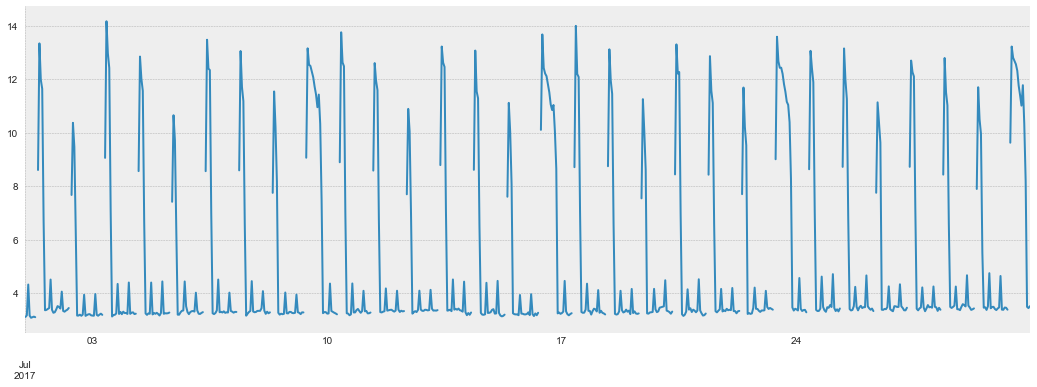

In [78]:
# 1 month
df_merged['2017-07-01':'2017-07-30'].plot(figsize=(18,6));

#### Fill missing data

In the above graph we can see that there are breaks in the data becasue the starting record of each day has prev_utilization as null hence the cpu_utilization_pctg is also null.

In [79]:
# to fill the gaps we use forward fill strategy, if there is a gap it is filled with last hours value
df_ffill = df_merged.fillna(method='ffill')

In [80]:
df_ffill.isnull().value_counts()

False    2184
Name: cpu_utilization_pctg, dtype: int64

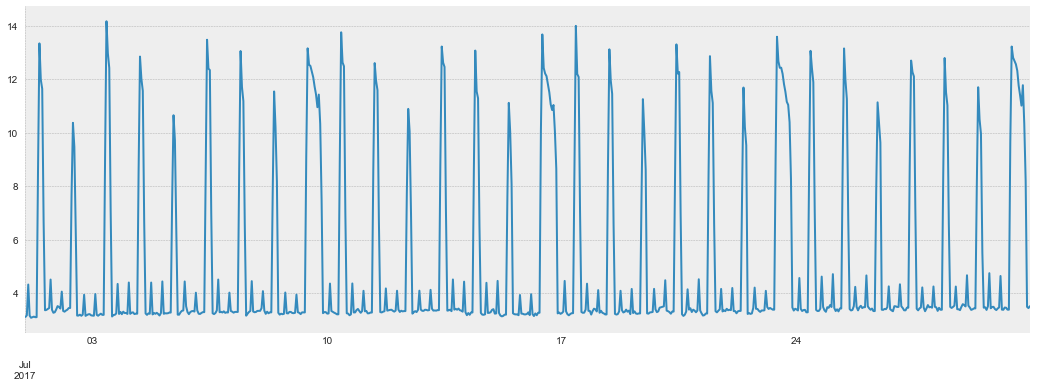

In [81]:
# 1 month
df_ffill['2017-07-01':'2017-07-30'].plot(figsize=(18,6));

In the above graph we can see that there is no break in the data now.

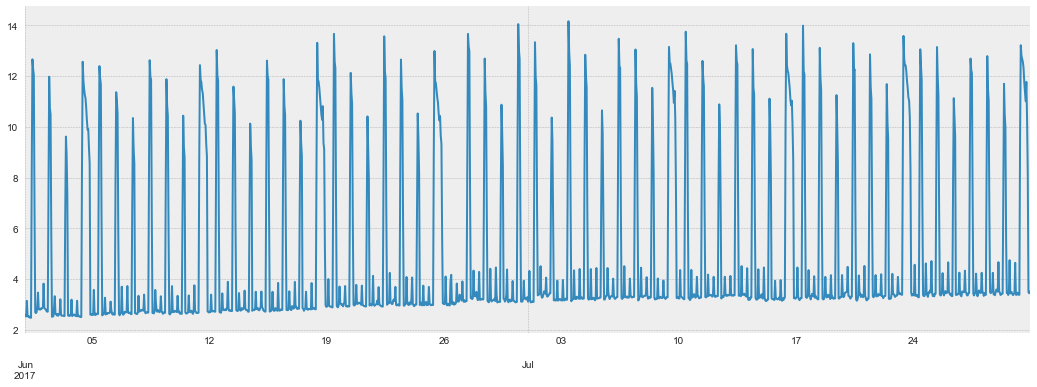

In [82]:
# 2 months
df_ffill['2017-06-01':'2017-07-30'].plot(figsize=(18,6));

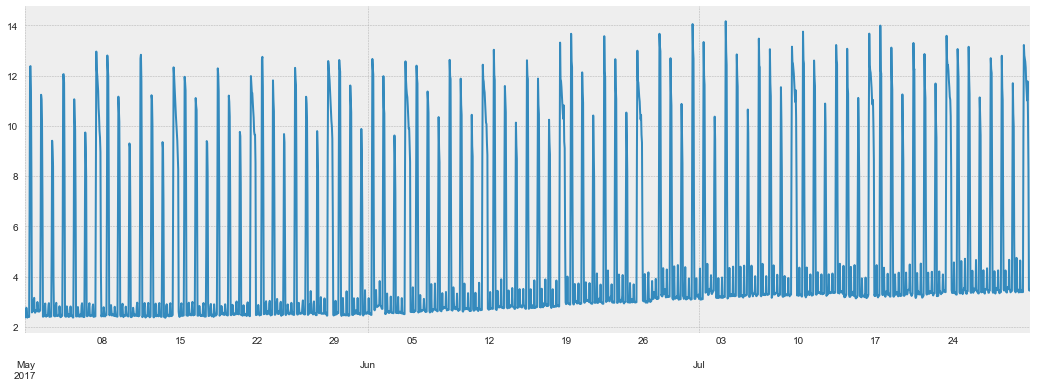

In [83]:
# 3 months
df_ffill['2017-05-01':'2017-07-30'].plot(figsize=(18,6));

### Simulate Anomaly on the Original cpu_utilization_pctg data

In [84]:
df_ffill_simulated = df_ffill.copy()

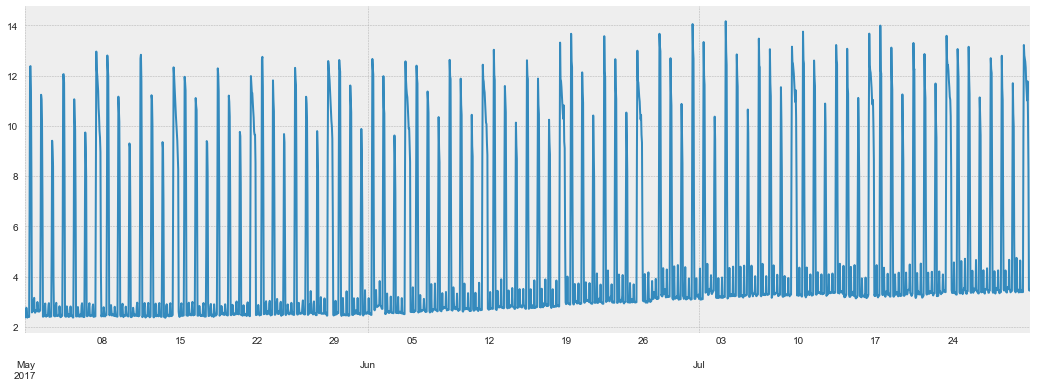

In [85]:
df_ffill_simulated.plot(figsize=(18,6));

#### Randomly pick some points and introduce anomaly

In [86]:
df_ffill_simulated.sample(5, random_state=23)

2017-07-08 17:00:00    3.227408
2017-05-05 04:00:00    2.431672
2017-06-19 22:00:00    3.004025
2017-07-12 18:00:00    4.094266
2017-05-31 10:00:00    9.879550
Name: cpu_utilization_pctg, dtype: float64

In [87]:
# Multiply the value by 5 for some random points
for index in df_ffill_simulated.sample(5, random_state=23).index:
    df_ffill_simulated[index] = df_ffill_simulated[index] * 5

In [88]:
df_ffill_simulated.sample(5, random_state=23)

2017-07-08 17:00:00    16.137040
2017-05-05 04:00:00    12.158362
2017-06-19 22:00:00    15.020124
2017-07-12 18:00:00    20.471332
2017-05-31 10:00:00    49.397752
Name: cpu_utilization_pctg, dtype: float64

In [89]:
df_ffill_simulated.index

DatetimeIndex(['2017-05-01 00:00:00', '2017-05-01 01:00:00',
               '2017-05-01 02:00:00', '2017-05-01 03:00:00',
               '2017-05-01 04:00:00', '2017-05-01 05:00:00',
               '2017-05-01 06:00:00', '2017-05-01 07:00:00',
               '2017-05-01 08:00:00', '2017-05-01 09:00:00',
               ...
               '2017-07-30 14:00:00', '2017-07-30 15:00:00',
               '2017-07-30 16:00:00', '2017-07-30 17:00:00',
               '2017-07-30 18:00:00', '2017-07-30 19:00:00',
               '2017-07-30 20:00:00', '2017-07-30 21:00:00',
               '2017-07-30 22:00:00', '2017-07-30 23:00:00'],
              dtype='datetime64[ns]', length=2184, freq=None)

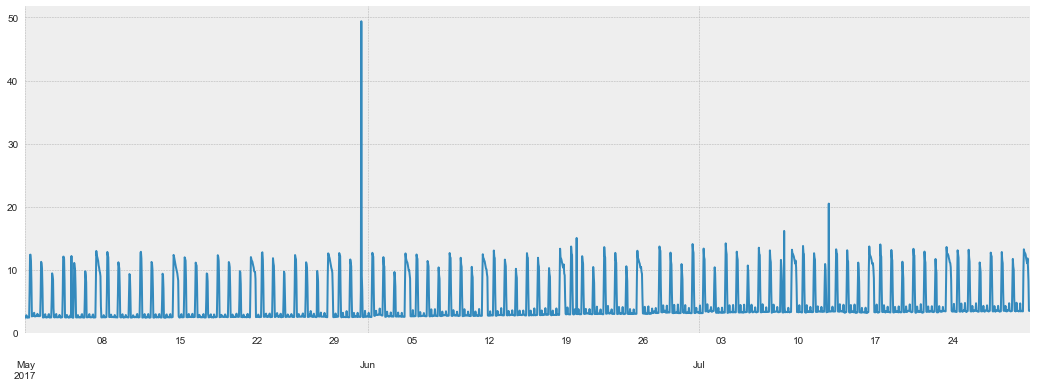

In [90]:
df_ffill_simulated.plot(figsize=(18,6));

In [91]:
df_ffill_simulated.index

DatetimeIndex(['2017-05-01 00:00:00', '2017-05-01 01:00:00',
               '2017-05-01 02:00:00', '2017-05-01 03:00:00',
               '2017-05-01 04:00:00', '2017-05-01 05:00:00',
               '2017-05-01 06:00:00', '2017-05-01 07:00:00',
               '2017-05-01 08:00:00', '2017-05-01 09:00:00',
               ...
               '2017-07-30 14:00:00', '2017-07-30 15:00:00',
               '2017-07-30 16:00:00', '2017-07-30 17:00:00',
               '2017-07-30 18:00:00', '2017-07-30 19:00:00',
               '2017-07-30 20:00:00', '2017-07-30 21:00:00',
               '2017-07-30 22:00:00', '2017-07-30 23:00:00'],
              dtype='datetime64[ns]', length=2184, freq=None)

### Data Exploration: Take 3 months of data

#### Take 3 months of data

In [92]:
df_ffill_simulated = df_ffill_simulated['2017-05-01':'2017-07-30']

#### Probability distribution of raw signal

The data is not normally distributed.

In [93]:
df_ffill_simulated.describe()

count    2184.000000
mean        4.644224
std         3.346234
min         2.363169
25%         2.648496
50%         3.205245
75%         4.251548
max        49.397752
Name: cpu_utilization_pctg, dtype: float64

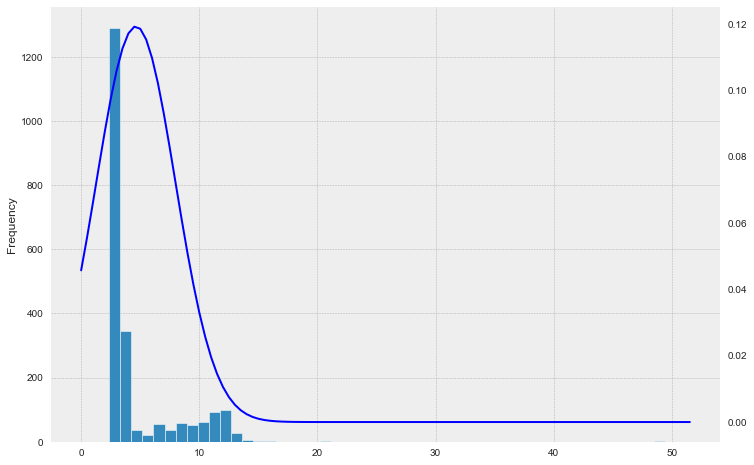

In [94]:
fig, ax1 = plt.subplots(figsize=(12,8))
ax2 = ax1.twinx()
ax2.grid(False)
df_ffill_simulated.plot.hist( stacked=True, bins=50, ax=ax1, edgecolor='white')

xmin,xmax,ymin,ymax = plt.axis()
x_axis = np.arange(xmin, xmax, 0.5)
plt.plot(x_axis, norm.pdf(x_axis,df_ffill_simulated.mean(),df_ffill_simulated.std()), color='blue');

#### Seasonal decomposition

In [95]:
n_sample = 24  # Number of readings in a day
#n_sample = 168  # Number of readings in a week

In [96]:
res = sm.tsa.seasonal_decompose(df_ffill_simulated, two_sided=False, freq=n_sample)

In [97]:
#dates = pd.date_range(start='2017-05-01 00:00:00', freq='1H', periods=len(df_ffill_simulated))
rf = pd.DataFrame(data=np.c_[df_ffill_simulated.values, res.trend, res.seasonal, res.resid], 
                  columns=['sampled', 'trend', 'seasonal', 'residual'], index=df_ffill_simulated.index)

In [98]:
rf.head(3)

,sampled,trend,seasonal,residual
2017-05-01 00:00:00,2.378500,NaN,-1.733780,NaN
2017-05-01 01:00:00,2.425676,NaN,-1.735710,NaN
2017-05-01 02:00:00,2.762292,NaN,-1.008143,NaN


In [99]:
df = rf.copy()
df.columns = ['actual_cpu_usage', 'trend', 'seasonal', 'residual_cpu_usage']
df.to_csv('df_ffill_simulated.csv', index_label='days', float_format='%.3f')

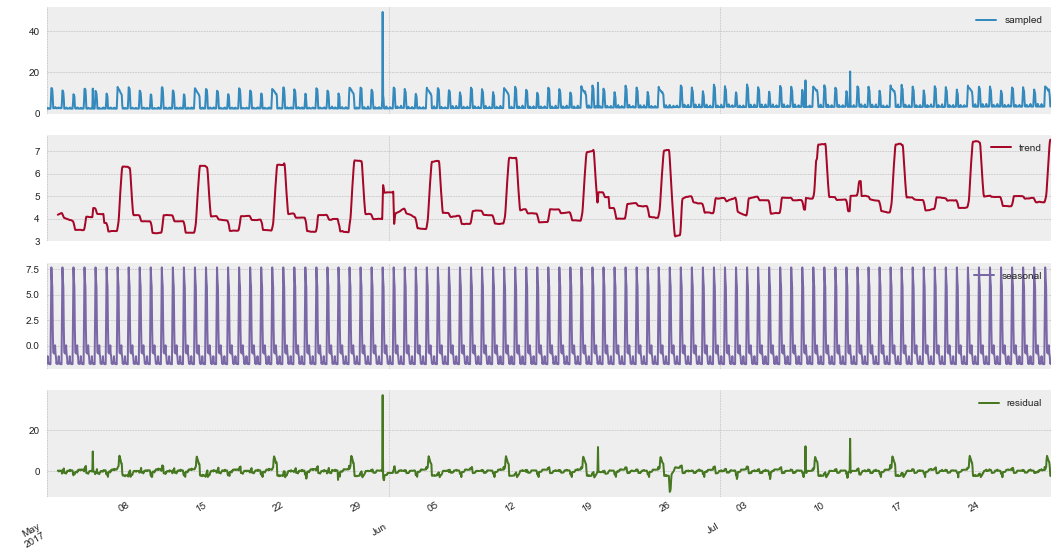

In [100]:
rf.plot(subplots=True, sharey=False, figsize=(18,10));

#### Probability distribution of the residual
Not looking at the 'residual' signal probability distribution we see it is a much better fit to a Normal distribution.

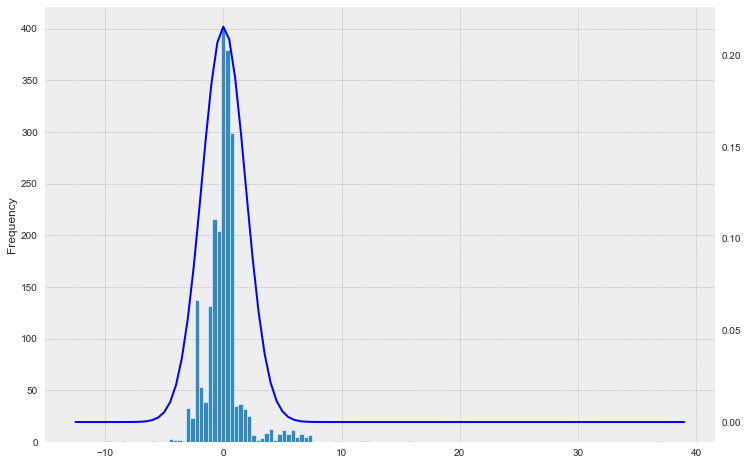

In [101]:
sf = rf.residual
fig, ax1 = plt.subplots(figsize=(12,8))
ax2 = ax1.twinx()
ax2.grid(False)
sf.plot.hist( stacked=True, bins=128, ax=ax1, edgecolor='white' )

xmin, xmax, ymin, ymax = plt.axis()
x_axis = np.arange(xmin, xmax, 0.5)
plt.plot(x_axis, norm.pdf(x_axis, sf.mean(), sf.std()), color='blue');

#### Running the generalizedESD test
With that established we can start looking for anomalies. This is done with Generalised ESD. Anomalies are marked in the diagram below.

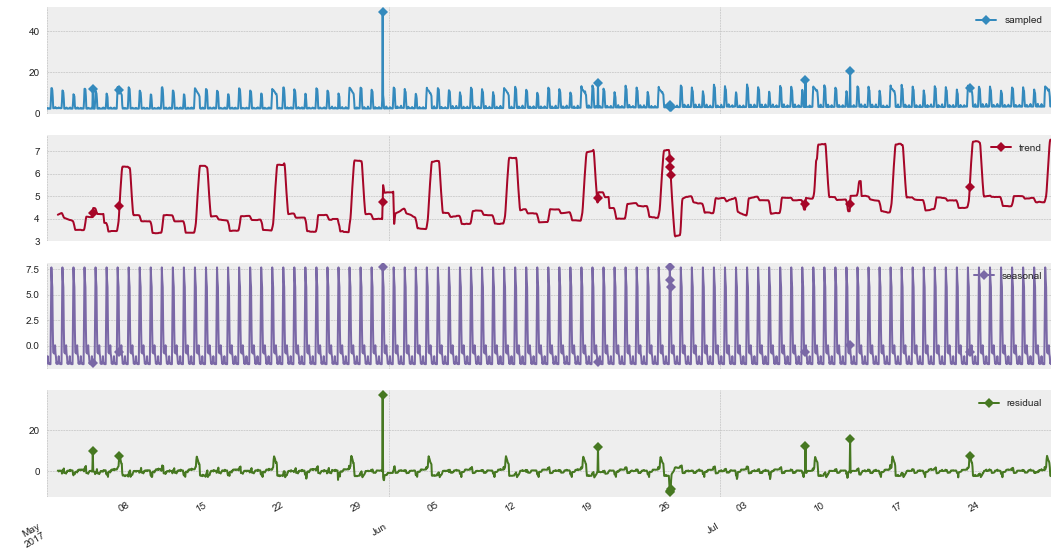

In [102]:
arr = rf['residual'][n_sample:]
nos, anomalies = pyasl.generalizedESD(x=arr, maxOLs=10, alpha=0.05, fullOutput=False) # maxOLs=10 maximum number of anomalous points we want to detect
mark = [x+n_sample for x in anomalies]
ax = rf.plot(subplots=True, sharey=False, marker='D', markevery=mark, figsize=(18, 10));

#### Visualy Inspect some of the anomalies (Not simulated by me)

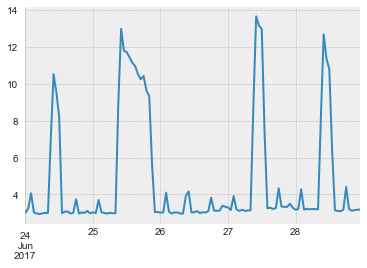

In [103]:
ax = plt.gca()
rf['2017-06-24':'2017-06-28']['sampled'].plot(ax=ax)
ax.grid(True, which='both')
plt.show()

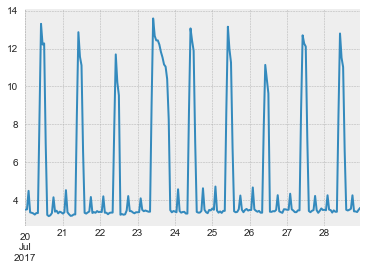

In [104]:
ax = plt.gca()
rf['2017-07-20':'2017-07-28']['sampled'].plot(ax=ax)
ax.grid(True, which='both')
plt.show()

#### Display detected anomalous points

In [105]:
mark.sort()
print(nos, mark)

10 [100, 158, 730, 1198, 1354, 1355, 1356, 1649, 1746, 2006]


In [106]:
af = rf.iloc[mark].copy()
af['hour'] = af.index.hour
af

,sampled,trend,seasonal,residual,hour
2017-05-05 04:00:00,12.158362,4.266530,-1.662608,9.554440,4
2017-05-07 14:00:00,11.392237,4.539020,-0.636742,7.489960,14
2017-05-31 10:00:00,49.397752,4.741577,7.666168,36.990007,10
2017-06-19 22:00:00,15.020124,4.916213,-1.603718,11.707629,22
2017-06-26 10:00:00,4.169469,6.654183,7.666168,-10.150883,10
2017-06-26 11:00:00,3.021887,6.287445,6.449887,-9.715445,11
2017-06-26 12:00:00,3.032206,5.923311,5.741228,-8.632332,12
2017-07-08 17:00:00,16.137040,4.663314,-0.605303,12.079029,17
2017-07-12 18:00:00,20.471332,4.668862,0.059307,15.743162,18
2017-07-23 14:00:00,12.204098,5.421882,-0.636742,7.418958,14


#### How different are the anomalous points from the median pctg values by hour?

**Calculate the median value of cpu_pctg by hour**

In [107]:
mf = pd.DataFrame(df_ffill_simulated)
mf['hour'] = mf.index.hour
mf = mf.groupby('hour').agg({'cpu_utilization_pctg': np.median}).reset_index()
mf.rename(columns={"cpu_utilization_pctg": "median_pctg"}, inplace=True)
mf

,hour,median_pctg
0,0,2.830096
1,1,2.879988
2,2,3.728395
3,3,2.984568
4,4,2.850645
5,5,2.783386
6,6,2.776690
7,7,2.742125
8,8,2.742125
9,9,7.710725


**Calculate the absolute %age deviation from the median values**

In [108]:
af['median_pctg'] = af['hour'].map(lambda x : mf.iloc[x]['median_pctg'])
af['pctg_diff'] = 100 * ((af['sampled'] - af['median_pctg']) / af['median_pctg'])
af['abs_pctg_diff'] = np.abs(af['pctg_diff'])

In [109]:
af

,sampled,trend,seasonal,residual,hour,median_pctg,pctg_diff,abs_pctg_diff
2017-05-05 04:00:00,12.158362,4.266530,-1.662608,9.554440,4,2.850645,326.512724,326.512724
2017-05-07 14:00:00,11.392237,4.539020,-0.636742,7.489960,14,2.991053,280.877101,280.877101
2017-05-31 10:00:00,49.397752,4.741577,7.666168,36.990007,10,12.310994,301.249077,301.249077
2017-06-19 22:00:00,15.020124,4.916213,-1.603718,11.707629,22,2.859938,425.190614,425.190614
2017-06-26 10:00:00,4.169469,6.654183,7.666168,-10.150883,10,12.310994,-66.132153,66.132153
2017-06-26 11:00:00,3.021887,6.287445,6.449887,-9.715445,11,11.542663,-73.819844,73.819844
2017-06-26 12:00:00,3.032206,5.923311,5.741228,-8.632332,12,11.110543,-72.708748,72.708748
2017-07-08 17:00:00,16.137040,4.663314,-0.605303,12.079029,17,3.033008,432.047447,432.047447
2017-07-12 18:00:00,20.471332,4.668862,0.059307,15.743162,18,3.826430,434.998275,434.998275
2017-07-23 14:00:00,12.204098,5.421882,-0.636742,7.418958,14,2.991053,308.020064,308.020064


In [110]:
af.sort_values(by='abs_pctg_diff',ascending=False)

,sampled,trend,seasonal,residual,hour,median_pctg,pctg_diff,abs_pctg_diff
2017-07-12 18:00:00,20.471332,4.668862,0.059307,15.743162,18,3.826430,434.998275,434.998275
2017-07-08 17:00:00,16.137040,4.663314,-0.605303,12.079029,17,3.033008,432.047447,432.047447
2017-06-19 22:00:00,15.020124,4.916213,-1.603718,11.707629,22,2.859938,425.190614,425.190614
2017-05-05 04:00:00,12.158362,4.266530,-1.662608,9.554440,4,2.850645,326.512724,326.512724
2017-07-23 14:00:00,12.204098,5.421882,-0.636742,7.418958,14,2.991053,308.020064,308.020064
2017-05-31 10:00:00,49.397752,4.741577,7.666168,36.990007,10,12.310994,301.249077,301.249077
2017-05-07 14:00:00,11.392237,4.539020,-0.636742,7.489960,14,2.991053,280.877101,280.877101
2017-06-26 11:00:00,3.021887,6.287445,6.449887,-9.715445,11,11.542663,-73.819844,73.819844
2017-06-26 12:00:00,3.032206,5.923311,5.741228,-8.632332,12,11.110543,-72.708748,72.708748
2017-06-26 10:00:00,4.169469,6.654183,7.666168,-10.150883,10,12.310994,-66.132153,66.132153


**Take top 5 points which deviate most from the median values**

In [111]:
af.nlargest(n=5, columns='abs_pctg_diff')

,sampled,trend,seasonal,residual,hour,median_pctg,pctg_diff,abs_pctg_diff
2017-07-12 18:00:00,20.471332,4.668862,0.059307,15.743162,18,3.826430,434.998275,434.998275
2017-07-08 17:00:00,16.137040,4.663314,-0.605303,12.079029,17,3.033008,432.047447,432.047447
2017-06-19 22:00:00,15.020124,4.916213,-1.603718,11.707629,22,2.859938,425.190614,425.190614
2017-05-05 04:00:00,12.158362,4.266530,-1.662608,9.554440,4,2.850645,326.512724,326.512724
2017-07-23 14:00:00,12.204098,5.421882,-0.636742,7.418958,14,2.991053,308.020064,308.020064
